# MFCC / speaker prediction

In [7]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [3]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [4]:
gender_dict = {k:v for k,v in obj}

In [5]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data

- sampling rate = 16000 Hz
- 200,000点で，200,000/16,000  = 12.5 sec
- 50 msec くらいで切りたいので，
- 50*10^-3 * 16,000 = 800 点ずつ切ればいい？
- 2の累乗にすると1024くらい？(0.064 sec)

In [23]:
all_data = np.empty((0,1024), int)
all_labels = []

cnt = 0
for path in glob.glob("wav_samples/*"):
    fs,data = load_wav(path)
    print(path)
    
    for i in range(int(data.shape[0]/1024)):
        all_data = np.append(all_data, np.array([data[i*1024:(i+1)*1024]]), axis=0)

    label = gender_dict[int(path.split("/")[1].split("-")[0])]
    all_labels.extend([label]*int(data.shape[0]/1024))
    
    cnt += 1
    if cnt > 80:
        break
    
print(all_data.shape)
all_labels = np.array(all_labels)

wav_samples/103-1240-0000.flac.wav
wav_samples/1034-121119-0000.flac.wav
wav_samples/1040-133433-0000.flac.wav
wav_samples/1069-133699-0000.flac.wav
wav_samples/1081-125237-0000.flac.wav
wav_samples/1088-129236-0000.flac.wav
wav_samples/1098-133695-0000.flac.wav
wav_samples/1116-132847-0000.flac.wav
wav_samples/118-121721-0000.flac.wav
wav_samples/1183-124566-0000.flac.wav
wav_samples/1235-135883-0000.flac.wav
wav_samples/1246-124548-0000.flac.wav
wav_samples/125-121124-0000.flac.wav
wav_samples/1263-138246-0000.flac.wav
wav_samples/1334-135589-0000.flac.wav
wav_samples/1355-39947-0000.flac.wav
wav_samples/1363-135842-0000.flac.wav
wav_samples/1447-130550-0000.flac.wav
wav_samples/1455-134435-0000.flac.wav
wav_samples/150-126107-0000.flac.wav
wav_samples/1502-122615-0000.flac.wav
wav_samples/1553-140047-0000.flac.wav
wav_samples/1578-140045-0000.flac.wav
wav_samples/1594-135914-0000.flac.wav
wav_samples/1624-142933-0000.flac.wav
wav_samples/163-121908-0000.flac.wav
wav_samples/1723-141

In [24]:
all_data.shape

(15561, 1024)

In [25]:
x_train = all_data[:15000]
y_train = all_labels[:15000]
x_test = all_data[15000:]
y_test = all_labels[15000:]

In [22]:
X_train = np.empty((0,1000),int)
Y_train = []
X_test = np.empty((0,1000),int)
Y_test = []
for j in range(10):
    for i in range(10):
        X_train = np.append(X_train,np.array([x_train[j][i:i+1000]]),axis= 0 )
        Y_train.append(y_train[j])
Y_train = np.array(Y_train)
        
for j in range(5):
    for i in range(10):
        X_test = np.append(X_test,np.array([x_test[j][i:i+1000]]),axis= 0 )
        Y_test.append(y_test[j])
Y_test = np.array(Y_test)

In [23]:
X_train = X_train.reshape(100,1000,1)
X_test = X_test.reshape(50,1000,1)

In [27]:
import wave
import numpy as np
import scipy.signal
import scipy.fftpack
import scipy.fftpack.realtransforms

def wavread(filename):
    wf = wave.open(filename, "r")
    fs = wf.getframerate()
    x = wf.readframes(wf.getnframes())
    x = np.frombuffer(x, dtype="int16") / 32768.0  # (-1, 1)に正規化
    wf.close()
    return x, float(fs)

def hz2mel(f):
    """Hzをmelに変換"""
    return 1127.01048 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをhzに変換"""
    return 700.0 * (np.exp(m / 1127.01048) - 1.0)

def melFilterBank(fs, nfft, numChannels):
    """メルフィルタバンクを作成"""
    # ナイキスト周波数（Hz）
    fmax = fs / 2
    # ナイキスト周波数（mel）
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大数
    nmax = nfft / 2
    # 周波数解像度（周波数インデックス1あたりのHz幅）
    df = fs / nfft
    # メル尺度における各フィルタの中心周波数を求める
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)
    # 各フィルタの開始位置のインデックス
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))

    filterbank = np.zeros((numChannels, int(nmax)))
    for c in np.arange(0, numChannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            i=int(i)
            filterbank[c, i] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            i=int(i)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)

def mfcc(signal, nfft, fs, nceps):
    """信号のMFCCパラメータを求める
    signal: 音声信号
    nfft  : FFTのサンプル数
    nceps : MFCCの次元"""
    # プリエンファシスフィルタをかける
    p = 0.97         # プリエンファシス係数
    signal = preEmphasis(signal, p)

    # ハミング窓をかける
    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow

    # 振幅スペクトルを求める
    spec = np.abs(np.fft.fft(signal, nfft))[:int(nfft/2)]
    fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:int(nfft/2)]

    # メルフィルタバンクを作成
    numChannels = 20  # メルフィルタバンクのチャネル数
    df = fs / nfft   # 周波数解像度（周波数インデックス1あたりのHz幅）
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)


    # 定義通りに書いた場合
    # 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、振幅の和の対数をとる
    mspec = np.log10(np.dot(spec, filterbank.T))


    # 離散コサイン変換
    ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)

    # 低次成分からnceps個の係数を返す
    return ceps[:nceps]

#wavファイルと次元数を入れてMFCCを抽出
#   nfft:FFTのサンプル数　1024, 2048, 4096
#   nceps:MFCCの次元数　大体12次元が多い
#   ※ fs * cuttime >= nfft/2 を満たす値を与えなければいけない
def get_feature(wavfile,nfft,nceps):
    # 音声をロード
    wav, fs = wavread(wavfile)
    t = np.arange(0.0, len(wav) / fs, 1/fs)
    
    # 音声波形の中心部分を切り出す
    center = len(wav) / 2  # 中心のサンプル番号
    cuttime = 0.8         # 切り出す長さ [s]
    wavdata = wav[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    
    ceps = mfcc(wavdata, nfft, fs, nceps)
    return ceps.tolist()

In [28]:
x_train.shape

(15000, 1024)

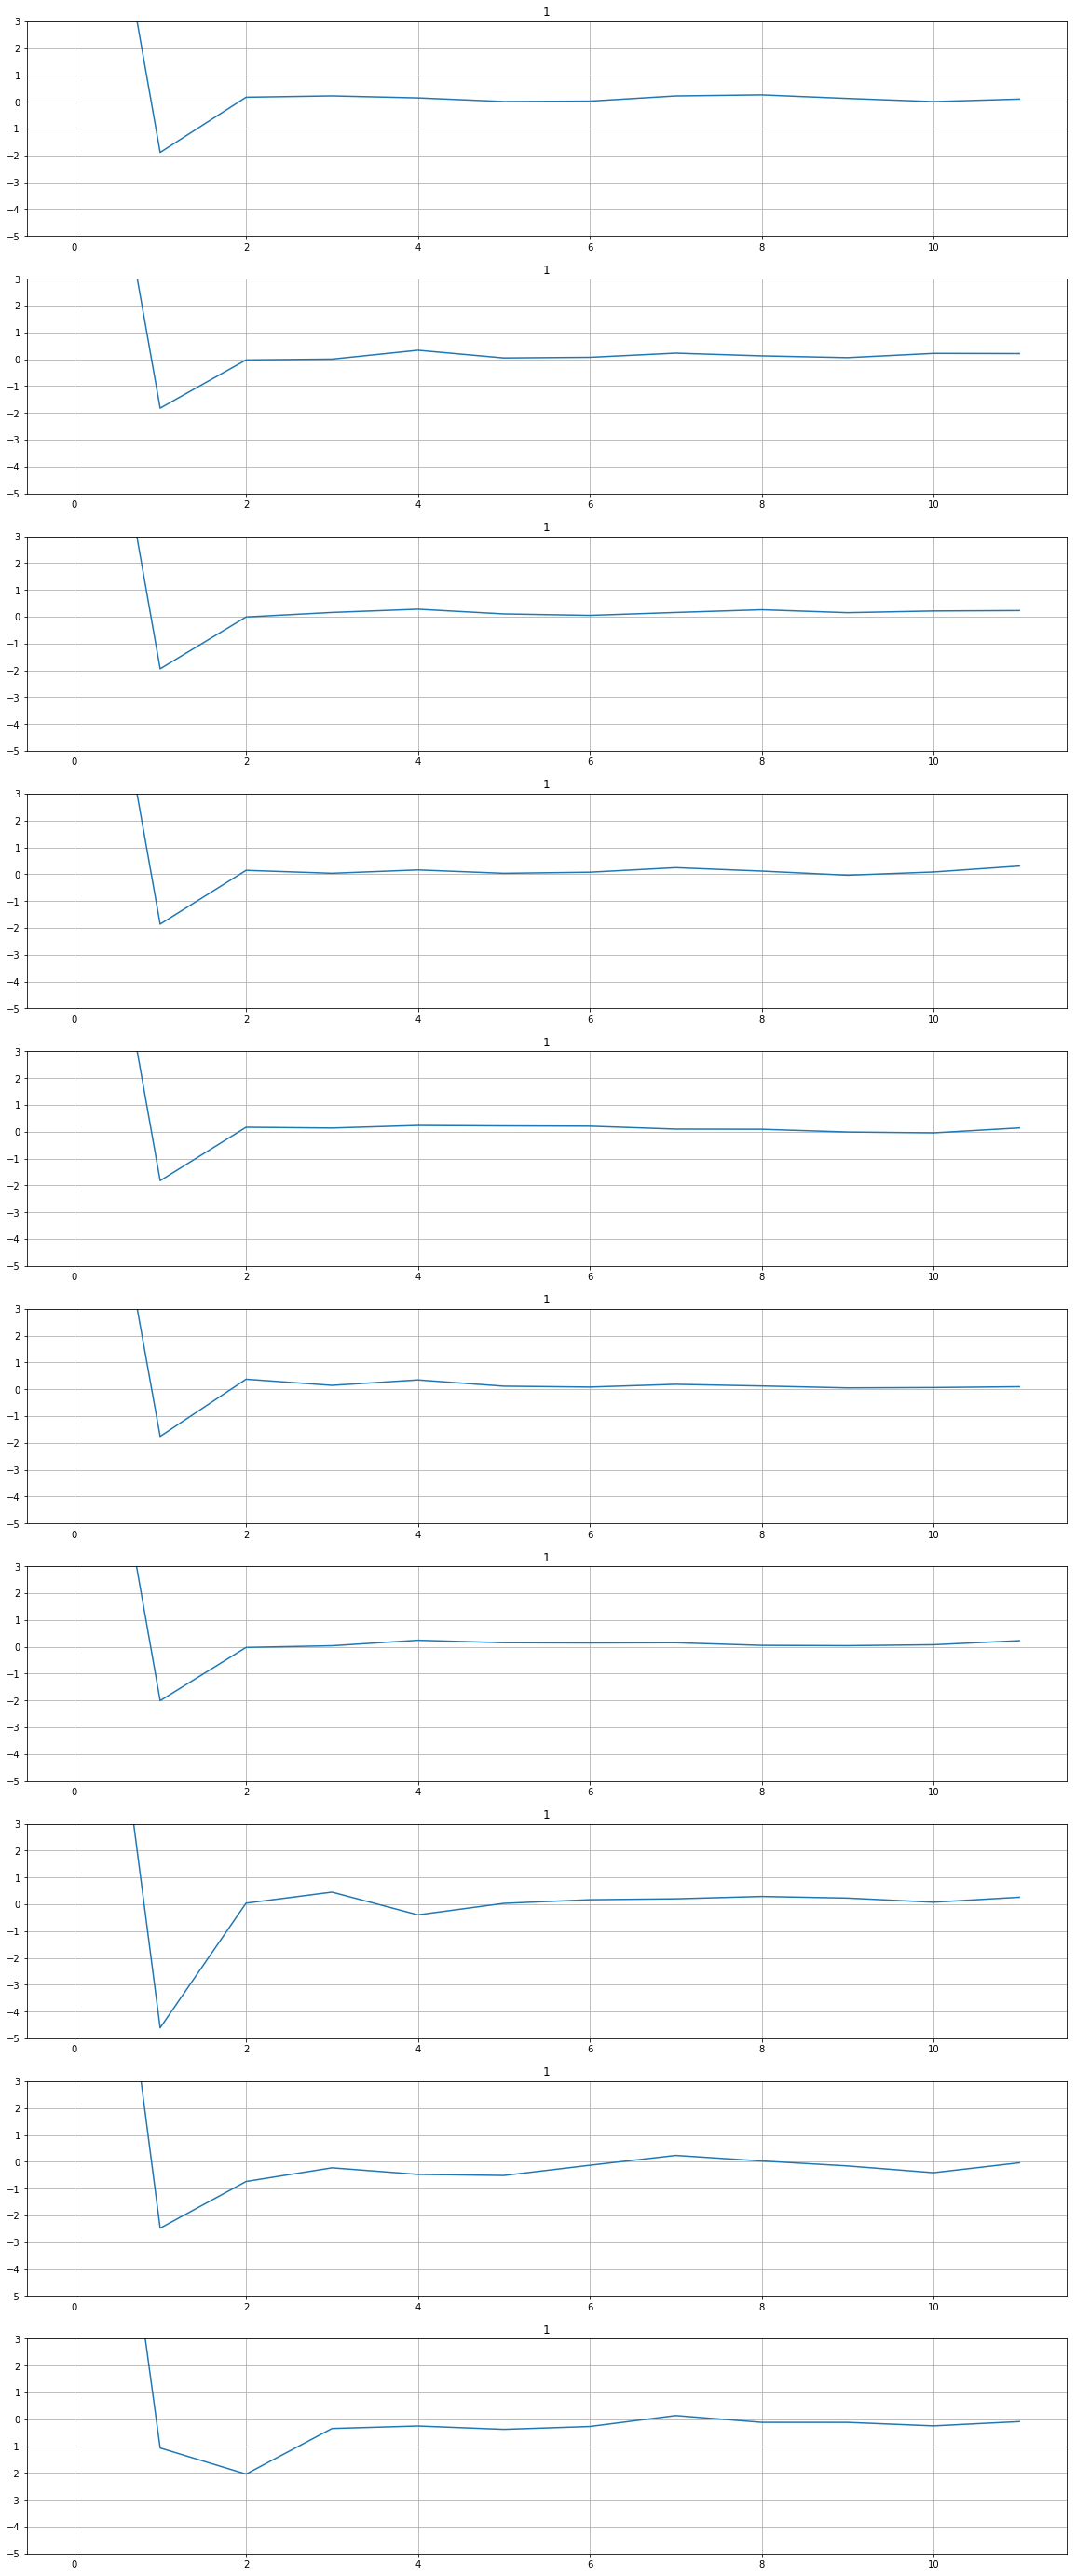

In [29]:
fig = plt.figure(figsize=(20,50))
for i in range(10):
    melbank = mfcc(x_train[i], len(x_train[i]),16000, 12)
    
    fig.add_subplot(10,1,i+1)
    plt.plot(melbank)
    plt.ylim(-5,3)
    plt.grid()
    plt.title(y_train[i])
plt.show()

In [75]:
X_train = np.array([mfcc(x, len(x),16000, 15) for x in x_train])

TypeError: mfcc() got an unexpected keyword argument 'hop_length'

In [76]:
X_test = np.array([mfcc(x, len(x),16000, 12) for x in x_test])

TypeError: mfcc() got an unexpected keyword argument 'hop_length'

In [77]:
import librosa
# mfccしてプロット
# print(x_train[0].shape)
mfccs = librosa.feature.mfcc(x_train[0], sr=16000, hop_length=2048)
# print(mfccs)
# plt.figure()
# plt.plot(mfccs)
# plt.show()
X_train = np.array([librosa.feature.mfcc(x, sr=16000, hop_length=2048) for x in x_train])
X_test = np.array([librosa.feature.mfcc(x,  sr=16000, hop_length=2048) for x in x_test])

In [87]:
X_train = X_train.reshape(-1,20)
X_test = X_test.reshape(-1,20)

[  1.63068688e+01  -1.89186527e+00   1.66521466e-01   2.15561376e-01
   1.41509822e-01   6.21286093e-03   2.04829490e-02   2.13805674e-01
   2.52676654e-01   1.21202750e-01   3.48935141e-03   9.65045485e-02
   8.43107570e-02   1.17991063e-01   2.44827255e-01   1.52630705e-01
   1.30460330e-01   1.96146499e-02   2.76904772e-02  -2.30532454e-02]


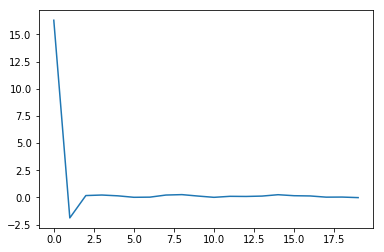

In [71]:
print(mfcc(x_train[0], len(x_train[0]),16000, 20))
plt.figure()
plt.plot(mfcc(x_train[0], len(x_train[0]),16000, 20))
plt.show()

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils

In [35]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [99]:
num_classes = 2
batch_size = 64
epochs = 200

# モデル構築
model = Sequential()

# 最初の隠れ層(入力1024-> 出力512)
model.add(Dense(15, activation='relu', input_shape=(20,)))
model.add(Dropout(0.2))

# 隠れ層(入力512 -> 出力512)
## 隠れ層は追加可能
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))

# 出力層(入力512 -> 出力:クラス数)
model.add(Dense(num_classes, activation='softmax'))

# モデル概要表示
model.summary()

# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# スコア計算・表示
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 15)                315       
_________________________________________________________________
dropout_38 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 5)                 80        
_________________________________________________________________
dropout_39 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 2)                 12        
Total params: 407
Trainable params: 407
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 561 samples
Epoch 1/200
15000/15000 [==============================] - 1s - loss: 7.1624 - acc: 0.5179 - val

15000/15000 [==============================] - 0s - loss: 0.5267 - acc: 0.7435 - val_loss: 0.5207 - val_acc: 0.7326
Epoch 57/200
15000/15000 [==============================] - 0s - loss: 0.5294 - acc: 0.7341 - val_loss: 0.5224 - val_acc: 0.7237
Epoch 58/200
15000/15000 [==============================] - 0s - loss: 0.5272 - acc: 0.7409 - val_loss: 0.4991 - val_acc: 0.7522
Epoch 59/200
15000/15000 [==============================] - 0s - loss: 0.5277 - acc: 0.7419 - val_loss: 0.5372 - val_acc: 0.7326
Epoch 60/200
15000/15000 [==============================] - 0s - loss: 0.5268 - acc: 0.7413 - val_loss: 0.4751 - val_acc: 0.7629
Epoch 61/200
15000/15000 [==============================] - 0s - loss: 0.5260 - acc: 0.7411 - val_loss: 0.4963 - val_acc: 0.7701
Epoch 62/200
15000/15000 [==============================] - 0s - loss: 0.5257 - acc: 0.7425 - val_loss: 0.5106 - val_acc: 0.7594
Epoch 63/200
15000/15000 [==============================] - 0s - loss: 0.5290 - acc: 0.7420 - val_loss: 0.5309

15000/15000 [==============================] - 0s - loss: 0.5167 - acc: 0.7485 - val_loss: 0.5188 - val_acc: 0.7273
Epoch 120/200
15000/15000 [==============================] - 0s - loss: 0.5196 - acc: 0.7495 - val_loss: 0.5093 - val_acc: 0.7469
Epoch 121/200
15000/15000 [==============================] - 0s - loss: 0.5198 - acc: 0.7441 - val_loss: 0.5031 - val_acc: 0.7576
Epoch 122/200
15000/15000 [==============================] - 0s - loss: 0.5192 - acc: 0.7426 - val_loss: 0.5059 - val_acc: 0.7594
Epoch 123/200
15000/15000 [==============================] - 0s - loss: 0.5200 - acc: 0.7399 - val_loss: 0.5124 - val_acc: 0.7415
Epoch 124/200
15000/15000 [==============================] - 0s - loss: 0.5235 - acc: 0.7431 - val_loss: 0.5023 - val_acc: 0.7540
Epoch 125/200
15000/15000 [==============================] - 0s - loss: 0.5238 - acc: 0.7391 - val_loss: 0.5114 - val_acc: 0.7522
Epoch 126/200
15000/15000 [==============================] - 0s - loss: 0.5219 - acc: 0.7448 - val_loss:

15000/15000 [==============================] - 0s - loss: 0.5128 - acc: 0.7466 - val_loss: 0.5410 - val_acc: 0.7451
Epoch 183/200
15000/15000 [==============================] - 0s - loss: 0.5148 - acc: 0.7447 - val_loss: 0.5247 - val_acc: 0.7576
Epoch 184/200
15000/15000 [==============================] - 0s - loss: 0.5169 - acc: 0.7433 - val_loss: 0.5020 - val_acc: 0.7683
Epoch 185/200
15000/15000 [==============================] - 0s - loss: 0.5191 - acc: 0.7445 - val_loss: 0.4866 - val_acc: 0.7718
Epoch 186/200
15000/15000 [==============================] - 0s - loss: 0.5175 - acc: 0.7414 - val_loss: 0.5136 - val_acc: 0.7469
Epoch 187/200
15000/15000 [==============================] - 0s - loss: 0.5218 - acc: 0.7431 - val_loss: 0.5149 - val_acc: 0.7487
Epoch 188/200
15000/15000 [==============================] - 0s - loss: 0.5170 - acc: 0.7436 - val_loss: 0.5012 - val_acc: 0.7594
Epoch 189/200
15000/15000 [==============================] - 0s - loss: 0.5210 - acc: 0.7435 - val_loss:

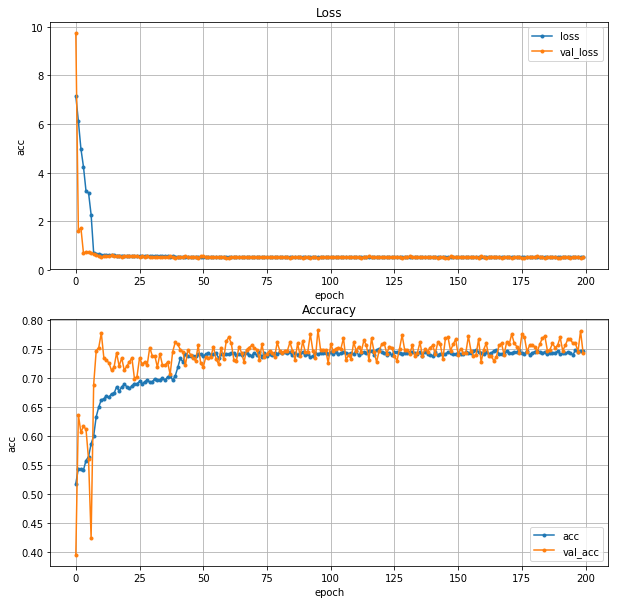

In [100]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')